# Mask R-CNN Model Evaluation

Evaluations of our pedestrian instance segmentation model.

## Import Libraries

In [251]:
import sys
import os
import glob
import re

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pyrealsense2 as rs
import cv2 as cv
import PIL
from PIL import Image
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark import layers as L

from predictor import PedestrianPredictor

print(f'Python version: {sys.version.split()[0]}')
print(f'Numpy version: {np.__version__}')
print(f'Matplotlib version: {matplotlib.__version__}')
print(f'OpenCV version: {cv.__version__}')
print(f'PIL version: {PIL.__version__}')

Python version: 3.6.8
Numpy version: 1.16.3
Matplotlib version: 3.1.0
OpenCV version: 4.0.1
PIL version: 6.0.0


## Plot Loss Over Time

In [6]:
LOG_FILE_PATH = "models/mask_rcnn_resnet_50_supervisely/log.txt"

In [7]:
with open(LOG_FILE_PATH) as f:
    lines = [l for l in f.readlines() if 'iter:' in l]

In [8]:
iters = []
losses = []
for line in lines:
    components = line.split(' ')
    iters.append(float(components[8]))
    losses.append(float(components[11]))

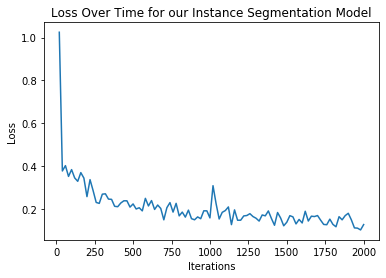

In [9]:
fig, ax = plt.subplots()
ax.plot(iters, losses)
ax.set(xlabel='Iterations', ylabel='Loss',
       title='Loss Over Time for our Instance Segmentation Model')
plt.show()

## Prepare Model for Inference

In [12]:
MODEL_CONFIG = 'models/mask_rcnn_resnet_50_supervisely/trained_supervisely_config.yaml'
CONFIDENCE_THRESHOLD = 0.7

In [13]:
# Load model config from file
cfg.merge_from_file(MODEL_CONFIG)
cfg.freeze()

# Prepare model predictor
predictor = PedestrianPredictor(
    cfg,
    confidence_threshold=CONFIDENCE_THRESHOLD
)

## Evaluate D435 RoI Fill Rates

In [73]:
DATA_DIR = '/media/adam/HDD Storage/Datasets/lighting-eval-data/'

In [113]:
condition_dirs = [d.split('/')[-2] for d in glob.glob(os.path.join(DATA_DIR, '*/'))]

for condition_dir in condition_dirs:
    image_paths = [f for f in glob.glob(os.path.join(DATA_DIR, condition_dir, '*Color*'))]
    depth_map_paths = [f for f in glob.glob(os.path.join(DATA_DIR, condition_dir, '*Depth*'))]

    fill_rates = []
    for image_path, depth_map_path in zip(image_paths, depth_map_paths):
        # Load image and depth map
        image = cv.imread(image_path)
        depth_map = cv.imread(depth_map_path)

        # Get pedestrian mask(s)
        predictions = predictor.compute_prediction(image)
        top_predictions = predictor.select_top_predictions(predictions)
        masks = predictions.get_field("mask").numpy()

        # Calculate RoI fill rate
        n_mask_pixels = 0
        n_depth_values = 0
        for mask in masks:
            mask = mask[0, :, :, None]
            mask_rows, mask_cols, _ = np.nonzero(mask)
            n_mask_pixels += len(mask_rows)
            depth_map_single_channel = cv.cvtColor(depth_map, cv.COLOR_RGB2GRAY)
            dm_roi = np.nonzero(depth_map_single_channel[mask_rows, mask_cols])
            n_depth_values += len(dm_roi[0])
        
        if n_mask_pixels == 0:
            fill_rate = 0
        else:
            fill_rate = n_depth_values / n_mask_pixels
        fill_rates.append(fill_rate)

    print(f'Fill Rate: {np.mean(fill_rates):.3f} ({np.std(fill_rates):.3f}) \t [{condition_dir}]')

Fill Rate: 0.846 (0.014) 	 [direct_sunlight_1m]
Fill Rate: 0.889 (0.013) 	 [direct_sunlight_2m]
Fill Rate: 0.911 (0.010) 	 [direct_sunlight_3m]
Fill Rate: 0.966 (0.009) 	 [direct_sunlight_4m]
Fill Rate: 0.979 (0.005) 	 [direct_sunlight_5m]
Fill Rate: 0.907 (0.003) 	 [dusk_1m]
Fill Rate: 0.923 (0.002) 	 [dusk_2m]
Fill Rate: 0.941 (0.002) 	 [dusk_3m]
Fill Rate: 0.973 (0.002) 	 [dusk_4m]
Fill Rate: 0.985 (0.002) 	 [dusk_5m]
Fill Rate: 0.913 (0.004) 	 [full_daylight_1m]
Fill Rate: 0.927 (0.003) 	 [full_daylight_2m]
Fill Rate: 0.963 (0.002) 	 [full_daylight_3m]
Fill Rate: 0.990 (0.001) 	 [full_daylight_4m]
Fill Rate: 0.991 (0.001) 	 [full_daylight_5m]
Fill Rate: 0.921 (0.006) 	 [overcast_1m]
Fill Rate: 0.935 (0.003) 	 [overcast_2m]
Fill Rate: 0.963 (0.003) 	 [overcast_3m]
Fill Rate: 0.985 (0.004) 	 [overcast_4m]
Fill Rate: 0.989 (0.004) 	 [overcast_5m]


## Run Detector on Single Image

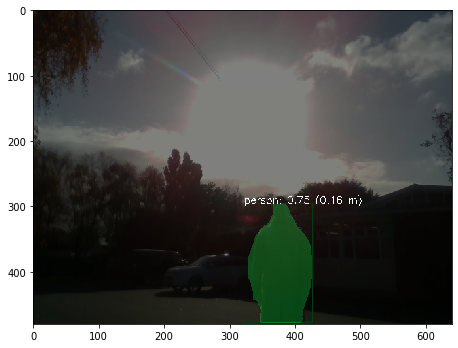

In [117]:
colour_path = '/media/adam/HDD Storage/Datasets/lighting-eval-data/direct_sunlight_4m/direct_sunlight_4m_Color_243.png'
depth_path = '/media/adam/HDD Storage/Datasets/lighting-eval-data/direct_sunlight_4m/direct_sunlight_4m_Depth_243.png'
colour_image = cv.imread(colour_path)
depth_image = cv.cvtColor(cv.imread(depth_path), cv.COLOR_RGB2GRAY)
detector_result = predictor.run_on_opencv_image(colour_image, depth_image * depth_scale)
plt.figure(figsize=(7.5, 7.5))
plt.imshow(detector_result)
plt.show()

## Evaluate Estimated Distances

The following emulates the behaviour of the detector on a number of evaluation frames.

In [282]:
def fetch_depth_map(bag, frame_num, post_process=True, scale=True):
    '''
    Fetch a depth map from a specific frame of a RealSense data bag.
    '''
    # Configure pipeline
    config = rs.config()
    config.enable_device_from_file(bag)

    pipeline = rs.pipeline() # Create a pipline
    profile = pipeline.start(config) # Start streaming
    align = rs.align(rs.stream.color) # Align infrared and depth images to colour image

    # Get depth sensor and scale information
    depth_sensor = profile.get_device().first_depth_sensor()
    depth_scale = depth_sensor.get_depth_scale()
    
    # Setup depth post-processing filters
    spat_filter = rs.spatial_filter() # Spatial - edge-preserving spatial smoothing
    hole_filter = rs.hole_filling_filter() # Hole - fill holes in depth map
    temp_filter = rs.temporal_filter() # Temporal - reduces temporal noise

    while True:
        frames = pipeline.wait_for_frames() # Read images from camera

        if frame_num == frames.get_depth_frame().get_frame_number():
            aligned_frames = align.process(frames)
            depth_frame = aligned_frames.get_depth_frame()
            
            if post_process:
                depth_frame = spat_filter.process(depth_frame)
                depth_frame = hole_filter.process(depth_frame)
                depth_frame = temp_filter.process(depth_frame)

            depth_image = np.asanyarray(depth_frame.get_data())
            depth_map = depth_image
            
            if scale:
                depth_map = depth_map * depth_scale
            
            pipeline.stop()

            return depth_map

In [257]:
condition_paths = [d for d in glob.glob(os.path.join(DATA_DIR, '*/'))]

for condition_path in condition_paths:
    condition_dir = condition_path.split('/')[-2] 
    condition_bag_path = condition_path[:-1] + '.bag'
    image_paths = [f for f in glob.glob(os.path.join(DATA_DIR, condition_dir, '*Color*'))]

    median_dists = []
    for image_path in image_paths:
        
        frame_num = int(re.findall(r'\d+', os.path.basename(image_path))[1])
        
        # Load image and depth map
        image = cv.imread(image_path)
        depth_map = fetch_depth_map(condition_bag_path, frame_num)
        
        # Get pedestrian mask
        predictions = predictor.compute_prediction(image)
        top_predictions = predictor.select_top_predictions(predictions)
        mask = predictions.get_field("mask").numpy()[0]

        # Calculate median distance
        mask = mask[0, :, :, None]
        mask_rows, mask_cols, _ = np.nonzero(mask)
        depth_values = depth_map[mask_rows, mask_cols]
        depth_values.flatten()
        depth_values = np.sort(depth_values)
        median_dist = np.median(depth_values)
        
        median_dists.append(median_dist)

    print(f'Mean Distance Estimate: {np.mean(median_dists):.3f} ({np.std(median_dists):.3f}) \t [{condition_dir}]')

Mean Distance Estimate: 1.244 (0.004) 	 [direct_sunlight_1m]
Mean Distance Estimate: 2.469 (0.019) 	 [direct_sunlight_2m]
Mean Distance Estimate: 3.621 (0.051) 	 [direct_sunlight_3m]
Mean Distance Estimate: 4.886 (0.049) 	 [direct_sunlight_4m]
Mean Distance Estimate: 6.767 (0.134) 	 [direct_sunlight_5m]
Mean Distance Estimate: 1.085 (0.001) 	 [dusk_1m]
Mean Distance Estimate: 2.111 (0.002) 	 [dusk_2m]
Mean Distance Estimate: 3.171 (0.003) 	 [dusk_3m]
Mean Distance Estimate: 4.390 (0.017) 	 [dusk_4m]
Mean Distance Estimate: 5.687 (0.033) 	 [dusk_5m]
Mean Distance Estimate: 1.196 (0.002) 	 [full_daylight_1m]
Mean Distance Estimate: 2.229 (0.011) 	 [full_daylight_2m]
Mean Distance Estimate: 3.248 (0.005) 	 [full_daylight_3m]
Mean Distance Estimate: 4.660 (0.014) 	 [full_daylight_4m]
Mean Distance Estimate: 6.015 (0.017) 	 [full_daylight_5m]
Mean Distance Estimate: 1.090 (0.004) 	 [overcast_1m]
Mean Distance Estimate: 2.103 (0.002) 	 [overcast_2m]
Mean Distance Estimate: 3.168 (0.005) 	 [o

/home/adam/.conda/envs/pytorch_36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adam/.conda/envs/pytorch_36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/adam/.conda/envs/pytorch_36/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/adam/.conda/envs/pytorch_36/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/adam/.conda/envs/pytorch_36/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Fetch Single Depth Map

In [279]:
# An arbitrary bag file from the camera to extract depth sensor info
VIDEO_FILE = '/media/adam/HDD Storage/Datasets/lighting-eval-data/direct_sunlight_4m.bag'

### 1. Filtered

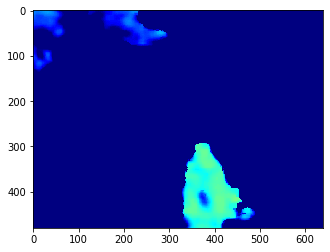

In [283]:
depth_map = fetch_depth_map(VIDEO_FILE, 240, scale=False)
depth_colormap = cv.applyColorMap(cv.convertScaleAbs(depth_map, alpha=0.03),
                                  cv.COLORMAP_JET)
plt.imshow(depth_colormap)
plt.show()

### 2. Unfiltered

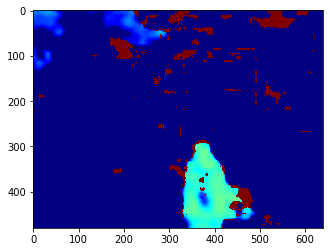

In [284]:
depth_map = fetch_depth_map(VIDEO_FILE, 240, post_process=False, scale=False)
depth_colormap = cv.applyColorMap(cv.convertScaleAbs(depth_map, alpha=0.03),
                                  cv.COLORMAP_JET)
plt.imshow(depth_colormap)
plt.show()